In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from os import listdir
from sklearn.preprocessing import StandardScaler
import umap
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib_venn import venn2, venn3

In [2]:
# taxfiles = listdir('../../MOTUS_TAX/')
# tax_values = []; samples = [];
# for f in taxfiles:
#     temp = pd.read_csv('../../MOTUS_TAX/'+f,skiprows=2,sep='\t')
#     tax_values.append(list(temp['unnamed sample']))
#     samples.append(f.split('_')[0])
# temp = pd.read_csv('../../MOTUS_TAX/A10_tax.txt',skiprows=2,sep='\t')
# taxnames = [ x for x in list(temp['#consensus_taxonomy'])]


# oral_tax = pd.DataFrame(zip(taxnames),columns=['Species'])
# for i in range(len(samples)):
#     oral_tax[samples[i]]=tax_values[i]
    
# oral_tax = oral_tax.set_index(['Species'])
# oral_tax = oral_tax.loc[(oral_tax !=0).any(axis=1)]
# oral_tax.to_csv('../data/metagenome/motus_profile.csv')

# Differential analysis for species-level microbial abundance

In [10]:
# from pydeseq2.dds import DeseqDataSet
# from pydeseq2.default_inference import DefaultInference
# from pydeseq2.ds import DeseqStats

In [9]:
# oral_tax = pd.read_csv('../data/metagenome/motus_profile.csv')
# spnames = [ x.split('[ref')[0].split('[meta')[0].split('[ext')[0].\
#            replace('[','').replace(']','').strip() for x in list(oral_tax['Species'])]
# oral_tax['Species'] = spnames
# oral_tax = oral_tax.rename(columns={'Species':'Sample'})

# meta = pd.DataFrame(zip(list(oral_tax.columns)[1:], 
#                     ['A' for i in range(10)] + ['B' for i in range(10)] ), columns=['Sample','Group'])
# meta = meta.set_index('Sample')
# oral_tax = oral_tax.set_index(['Sample'])
# for k in oral_tax.columns:
#     temp = [ int(x*1e5) for x in list(oral_tax[k]) ]
#     oral_tax[k] = temp
# oral_tax = oral_tax.T
# oral_quant = oral_tax.groupby(oral_tax.columns, axis=1).sum()

# inference = DefaultInference()
# dds = DeseqDataSet( counts= oral_quant, metadata= meta,
#     design_factors="Group", refit_cooks=True,ref_level= ["Group", "A"], inference=inference )

In [8]:
# dds.deseq2()
# print(dds)

In [7]:
# diffanalysis = DeseqStats(dds,contrast= ['Group', 'B', 'A'], inference=inference)
# diffanalysis.summary()

In [6]:
# diffanalysis.results_df.to_csv("../data/metagenome/sps_deg.csv")

In [2]:
def volcano( table, lfc_col, pv_col, lfc_cutoff, pv_cutoff, size, ax):
    lfc_list = list(table[lfc_col])
    mlg10pv = [ -np.log10(x) for x in list(table[pv_col]) ]
    x_cut1 = lfc_cutoff; x_cut2 = - lfc_cutoff;
    y_cut = -np.log10( pv_cutoff )
    color_list = []
    for i in range(len(lfc_list) ):
        if mlg10pv[i] > y_cut:
            if lfc_list[i] > x_cut1:
                color_list.append('red')
            elif lfc_list[i] < x_cut2:
                color_list.append('blue')
            else:
                color_list.append('grey')
        else:
            color_list.append('grey')
    ax.scatter(lfc_list, mlg10pv, c=color_list, marker='o',linewidth=0.5,edgecolor='black',s=size, alpha=0.5)
    ax.axhline(y=y_cut, color='grey', linestyle='--')
    ax.axvline(x=x_cut1, color='grey', linestyle='--')
    ax.axvline(x=x_cut2, color='grey', linestyle='--')
    return ax

def annot_volcano( table, name_col, lfc_col, pv_col, lfc_cutoff, pv_cutoff, fontsize, ax ):
    x_cut1 = lfc_cutoff; x_cut2 = - lfc_cutoff;
    y_cut = -np.log10( pv_cutoff )
    
    sig_table = table[ ( (table[lfc_col]>x_cut1) | (table[lfc_col]<x_cut2) ) & (table[pv_col]<pv_cutoff)  ]
    sig_table = sig_table.reset_index().drop(['index'],axis=1)
    x_list = list(sig_table[lfc_col])
    y_list = [ -np.log10(x) for x in list(sig_table[pv_col]) ]
    names = list(sig_table[name_col])
    
    for i in range(len(x_list)):
        if x_list[i] >0:
            ax.text(0.9*x_list[i], y_list[i]*0.99, s=names[i], fontsize=fontsize)
        else:
            ax.text(1.01*x_list[i], y_list[i]*0.99, s=names[i], fontsize=fontsize)   
    return ax

In [20]:
spdeg = pd.read_csv('../data/metagenome/sps_deg.csv')
spdeg= spdeg.rename(columns={'Sample':'Species'})
spdeg = spdeg.dropna()

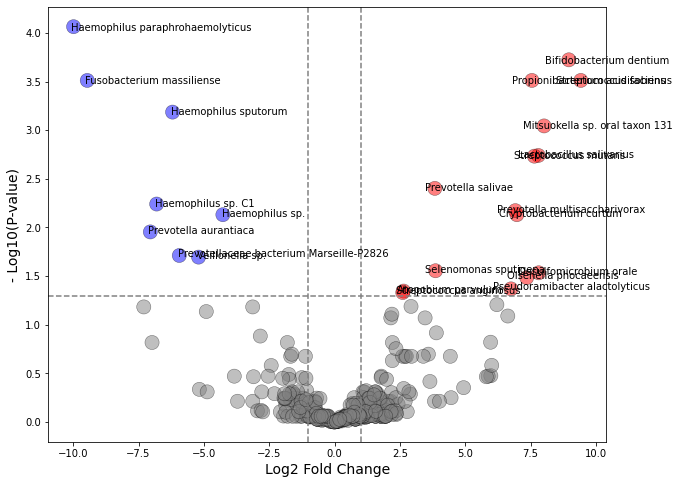

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
volcano( spdeg, 'log2FoldChange', 'padj', 1.0, 0.05, 200, ax=ax)
ax.set_xlabel('Log2 Fold Change',fontsize=14)
ax.set_ylabel('- Log10(P-value)',fontsize=14)
annot_volcano( spdeg,'Species' ,'log2FoldChange', 'padj', 1.0, 0.05, 10, ax=ax );
ax.

# UMAP

In [2]:
oral_tax = pd.read_csv('../data/metagenome/motus_profile.csv')
spnames = [ x.split('[ref')[0].split('[meta')[0].split('[ext')[0].\
           replace('[','').replace(']','').strip() for x in list(oral_tax['Species'])]
oral_tax['Species'] = spnames; oral_tax = oral_tax.rename(columns={'Species':'Sample'})
oral_tax = oral_tax.set_index(['Sample'])
oral_tax = oral_tax.T; oral_quant = oral_tax.groupby(oral_tax.columns, axis=1).sum();
threshold = pd.read_csv('../data/metagenome/Thresholds.csv')
oral_quant.head()

Sample,Abiotrophia defectiva,Acidaminococcus species incertae sedis,Acidovorax wautersii,Acinetobacter baumannii,Actinobacteria sp.,Actinobaculum sp. oral taxon 183,Actinomyces bouchesdurhonensis,Actinomyces dentalis,Actinomyces gerencseriae,Actinomyces graevenitzii,...,Veillonella denticariosi,Veillonella dispar,Veillonella parvula,Veillonella rogosae,Veillonella sp.,Veillonella species incertae sedis,Veillonella tobetsuensis,Weissella confusa,Weissella paramesenteroides,unassigned
A10,0.000198,0.0,0.0,0.000000,0.003645,0.000081,0.000000,0.000277,0.000086,0.005495,...,0.0,0.002468,0.001105,0.041786,0.001101,0.003468,0.004988,0.0,0.0,0.071457
A11,0.000440,0.0,0.0,0.000000,0.008368,0.000030,0.016645,0.000115,0.000046,0.016826,...,0.0,0.015411,0.003669,0.000787,0.000278,0.039186,0.000157,0.0,0.0,0.034749
A1,0.010644,0.0,0.0,0.000000,0.003527,0.000910,0.000000,0.000773,0.000822,0.001720,...,0.0,0.001753,0.003181,0.011843,0.013361,0.006406,0.002494,0.0,0.0,0.043114
A20,0.000000,0.0,0.0,0.000672,0.008431,0.001276,0.000000,0.001029,0.001319,0.004478,...,0.0,0.004752,0.022527,0.007487,0.002804,0.016425,0.000000,0.0,0.0,0.035508
A28,0.003256,0.0,0.0,0.000000,0.001518,0.000587,0.000000,0.000649,0.000553,0.000000,...,0.0,0.000752,0.003571,0.018238,0.001710,0.003183,0.001323,0.0,0.0,0.042862


In [3]:
X = oral_tax.iloc[:,1:].values
X = StandardScaler().fit_transform(X)
reducer_sp = umap.UMAP(random_state=42)
embedding = reducer_sp.fit_transform(X)
umap_pd = pd.DataFrame(embedding, columns =['UMAP-1','UMAP-2'])
umap_pd['Group'] = ['A (20~30yr)' for i in range(10)] + ['B (55~80yr)' for i in range(10)]

/home/bras5181/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


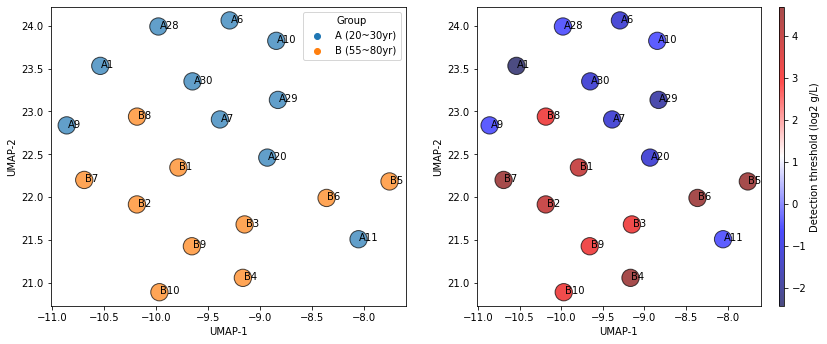

In [25]:
fig, axs = plt.subplots(1,2,figsize=(14,5.5))
sns.scatterplot(x='UMAP-1', y='UMAP-2',hue="Group",
            linewidth=1,data=umap_pd, s=300, alpha=0.7, edgecolor='black', ax=axs[0])
for i in range(len(umap_pd.index)):
    x,y=list(umap_pd['UMAP-1'])[i]*0.999, list(umap_pd['UMAP-2'])[i]*0.999
    axs[0].text(x,y,s=list(oral_quant.index)[i])
pt1=axs[1].scatter( umap_pd['UMAP-1'], umap_pd['UMAP-2'], c=np.log2(threshold['Detection threshold']), 
                   cmap='seismic',alpha=0.7,s=300, edgecolor='black')
plt.colorbar(pt1, label='Detection threshold (log2 g/L)', aspect=50)
for i in range(len(umap_pd.index)):
    x,y=list(umap_pd['UMAP-1'])[i]*0.999, list(umap_pd['UMAP-2'])[i]*0.999
    axs[1].text(x,y,s=list(oral_quant.index)[i])
for ax in axs:
    ax.set_xlabel('UMAP-1'); ax.set_ylabel('UMAP-2')

In [73]:
A_quant = oral_quant.iloc[:10].drop(['unassigned'],axis=1); B_quant=oral_quant.iloc[10:].drop(['unassigned'],axis=1);
Asp_avg = pd.DataFrame( A_quant.mean(axis=0), columns=['Average']).sort_values(['Average'],ascending=False)
Bsp_avg = pd.DataFrame( B_quant.mean(axis=0), columns=['Average']).sort_values(['Average'],ascending=False)

In [79]:
genus_abund = pd.read_csv('../data/metagenome/16S.csv').drop(['16S_index'],axis=1).set_index('Sample')
old_cols = list(genus_abund.columns)
for k in old_cols:
    genus_abund = genus_abund.rename(columns={k: k.replace('g__','').replace('unclassified_','').replace('p__','').\
               replace('f__','').replace('o__','').replace('norank_','')})
A_genus=genus_abund.iloc[:10]; B_genus = genus_abund.iloc[10:];
Ag_avg = pd.DataFrame( A_genus.mean(axis=0), columns=['Average']).sort_values(['Average'],ascending=False)
Bg_avg = pd.DataFrame( B_genus.mean(axis=0), columns=['Average']).sort_values(['Average'],ascending=False)

# MAGs

In [26]:
Abin_quant = pd.read_csv('../data/metagenome/A_abundance_table.tab',sep='\t');
Bbin_quant = pd.read_csv('../data/metagenome/B_abundance_table.tab',sep='\t');
Abin_qc = pd.read_csv('../data/metagenome/A_metawrap_90_5_bins.stats',sep='\t');
Bbin_qc = pd.read_csv('../data/metagenome/B_metawrap_90_5_bins.stats',sep='\t');

In [3]:
# Aclass = pd.read_csv('../data/metagenome/A_gtdbtk_summary.tsv',sep='\t');
# Bclass = pd.read_csv('../data/metagenome/B_gtdbtk_summary.tsv',sep='\t');
# def process_class(text):
#     g = text.split(';g__')[1].split(';s__')[0].strip()
#     sp=text.split(';s__')[1]
#     if sp=='':
#         sp='unknown'
#     return {'genus':g,'species':sp}  

In [4]:
# bins=list(Aclass.user_genome)
# tax=[ process_class(text) for text in Aclass.classification]
# Aclass_pd = pd.DataFrame(tax); Aclass_pd['bin_id']=bins;
# Aclass_pd.to_csv('../data/metagenome/A_species.csv',index=None);
# bins=list(Bclass.user_genome)
# tax=[ process_class(text) for text in Bclass.classification]
# Bclass_pd = pd.DataFrame(tax); Bclass_pd['bin_id']=bins;
# Bclass_pd.to_csv('../data/metagenome/B_species.csv',index=None);

In [27]:
Aclass = pd.read_csv('../data/metagenome/A_species.csv');
Bclass = pd.read_csv('../data/metagenome/B_species.csv');

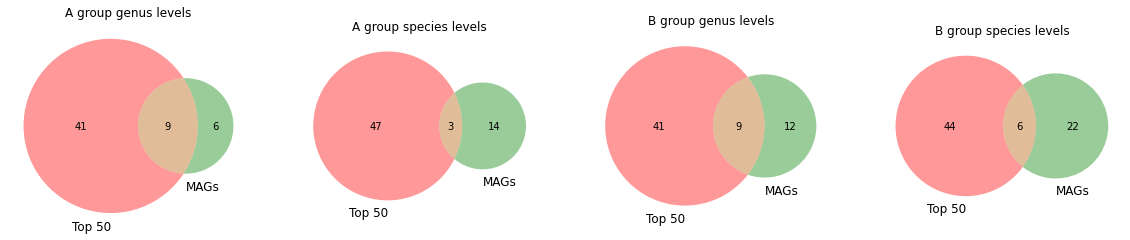

In [105]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
o1=venn2([set(list(Ag_avg.index)[:50]),set(Aclass['genus'])],set_labels=('Top 50','MAGs'),ax=axs[0])
o2=venn2([set(list(Asp_avg.index)[:50]),set(Aclass['species'])],set_labels=('Top 50','MAGs'),ax=axs[1])
o3=venn2([set(list(Bg_avg.index)[:50]),set(Bclass['genus'])],set_labels=('Top 50','MAGs'),ax=axs[2])
o4=venn2([set(list(Bsp_avg.index)[:50]),set(Bclass['species'])],set_labels=('Top 50','MAGs'),ax=axs[3])
axs[0].set_title('A group genus levels'); axs[1].set_title('A group species levels');
axs[2].set_title('B group genus levels'); axs[3].set_title('B group species levels');

(-0.1, 5.5)

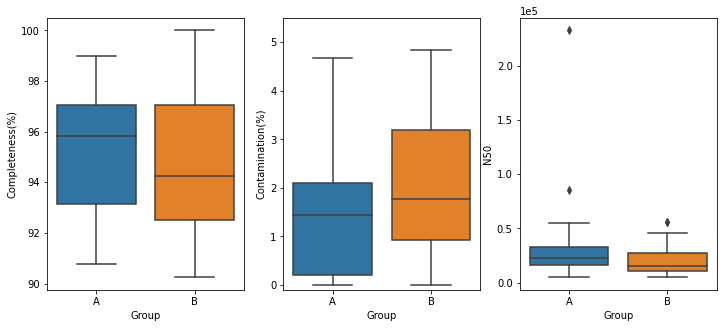

In [18]:
fig, axs = plt.subplots(1,3,figsize=(12,5))
targets = ['completeness','contamination','N50']
for i in range(3):
    temp = pd.DataFrame(zip(list(Abin_qc[targets[i]])+list(Bbin_qc[targets[i]]),
            ['A' for i in range(len(Abin_qc.index)) ]+['B' for i in range(len(Bbin_qc.index))]),
                       columns=[targets[i], 'Group'])
    sns.boxplot(data=temp,x='Group',y=targets[i], ax= axs[i])
axs[2].ticklabel_format(axis='y', style='sci',scilimits=(4,5))
axs[0].set_ylabel('Completeness(%)'); axs[1].set_ylabel('Contamination(%)');
axs[1].set_ylim([-0.1,5.5])

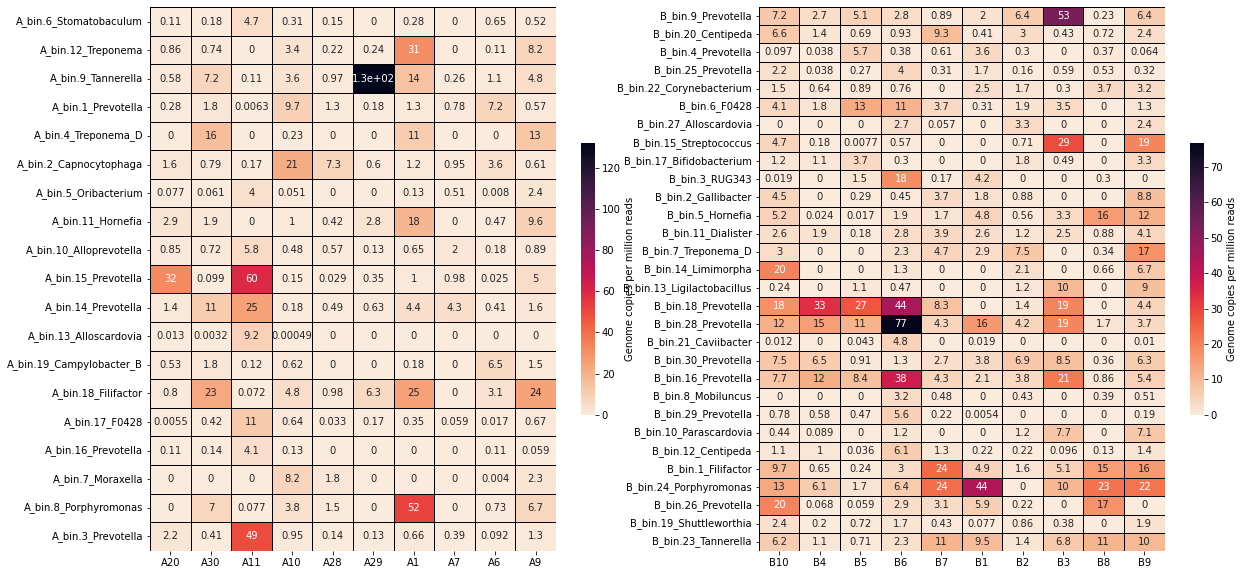

In [119]:
Aticks = [ 'A_'+x+'_'+list(Aclass[Aclass['bin_id']==x]['genus'])[0]for x in Abin_quant['Genomic bins']]
Bticks = [ 'B_'+x+'_'+list(Bclass[Bclass['bin_id']==x]['genus'])[0]for x in Bbin_quant['Genomic bins']]
fig, axs = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(data=Abin_quant.iloc[:,1:], yticklabels=Aticks,cmap ="rocket_r",
            cbar_kws={"shrink": 0.5,'label':'Genome copies per million reads'},
            linewidths=0.8,linecolor="black",annot=True,ax=axs[0]);
sns.heatmap(data=Bbin_quant.iloc[:,1:],yticklabels=Bticks,cmap ="rocket_r",
            cbar_kws={"shrink": 0.5, 'label':'Genome copies per million reads'},
            linewidths=0.8,linecolor="black",annot=True,ax=axs[1]);

## QS proteins

In [6]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [8]:
# qs_records=[]
# for i in range(len(qsdb.index)):
#     seq = list(qsdb['AA senquence'])[i].strip()
#     ID = 'ID:'+list(qsdb['QS protein'])[i] + ' Type:' + list(qsdb['Protein type'])[i]
#     qs_records.append( SeqRecord(Seq(seq), id = ID, name="",description="") )
# SeqIO.write(qs_records, '../data/metagenome/qs_proteins.fasta' ,"fasta")

213

In [15]:
def comple_array(arr1,arr2):
    arr = arr1+arr2
    arr = arr>0
    return [int(x) for x in arr]

In [16]:
qsdb = pd.read_csv('../data/metagenome/QSdb.csv')
all_qs = list(np.unique( qsdb['Protein type']))
blast_files = listdir('../data/QS_blast/')
qs_data = []
for f in blast_files:
    temp = {k:0 for k in all_qs}
    temp['bin_id'] = f.replace('.QS.txt','')
    temp_pd = pd.read_csv( '../data/QS_blast/'+f,comment='#', sep='\t', header=None)
    temp_pd.columns=['query_id', 'subject_id', 'percent_identity', 'alignment_length',
              'mismatches', 'gap_opens', 'query_start', 'query_end','subject_start', 'subject_end', 'e_value', 'bit_score']
    matched = list( np.unique( list(temp_pd['query_id']) ) )
    matched = [x.replace('ID:','') for x in matched]
    found_types = np.unique( list( qsdb[qsdb['QS protein'].isin(matched)]['Protein type'] ) )
    for k in found_types:
         temp[k] = 1
    qs_data.append(temp)
qs_matched = pd.DataFrame(qs_data)
for col in qs_matched.columns:
    if '/' in col:
        qs_matched[col.split('/')[0]]=list(qs_matched[col])
        qs_matched[col.split('/')[1]]= comple_array(qs_matched[col],qs_matched[col.split('/')[1]])
        qs_matched = qs_matched.drop([col],axis=1)

In [20]:
# qs_matched = qs_matched.rename(columns={'4-hydroxy-3-(11-methyldodecyl)-6-(2-methylpropyl)-pyranone synthases':'Pyranone synthases'})
# qs_matched = qs_matched.set_index(['bin_id'])
# qs_matched.to_csv('../data/metagenome/QS_matched.csv')

In [21]:
Aclass = pd.read_csv('../data/metagenome/A_species.csv');
Bclass = pd.read_csv('../data/metagenome/B_species.csv');
qs_matched = pd.read_csv('../data/metagenome/QS_matched.csv')
qs_matched = qs_matched.rename(columns={'bin_id':'QS proteins'})
qs_matched = qs_matched.set_index(['QS proteins'])
qs_matched = qs_matched.T
for bin_id in Aclass.bin_id:
    qs_matched = qs_matched.rename(columns={'A_'+bin_id:'A_'+bin_id+'_'\
                                            +list(Aclass[Aclass['bin_id']==bin_id]['genus'])[0] })
for bin_id in Bclass.bin_id:
    qs_matched = qs_matched.rename(columns={'B_'+bin_id:'B_'+bin_id\
                                            +'_'+list(Bclass[Bclass['bin_id']==bin_id]['genus'])[0] })  

Text(1448.3750000000002, 0.5, 'QS proteins')

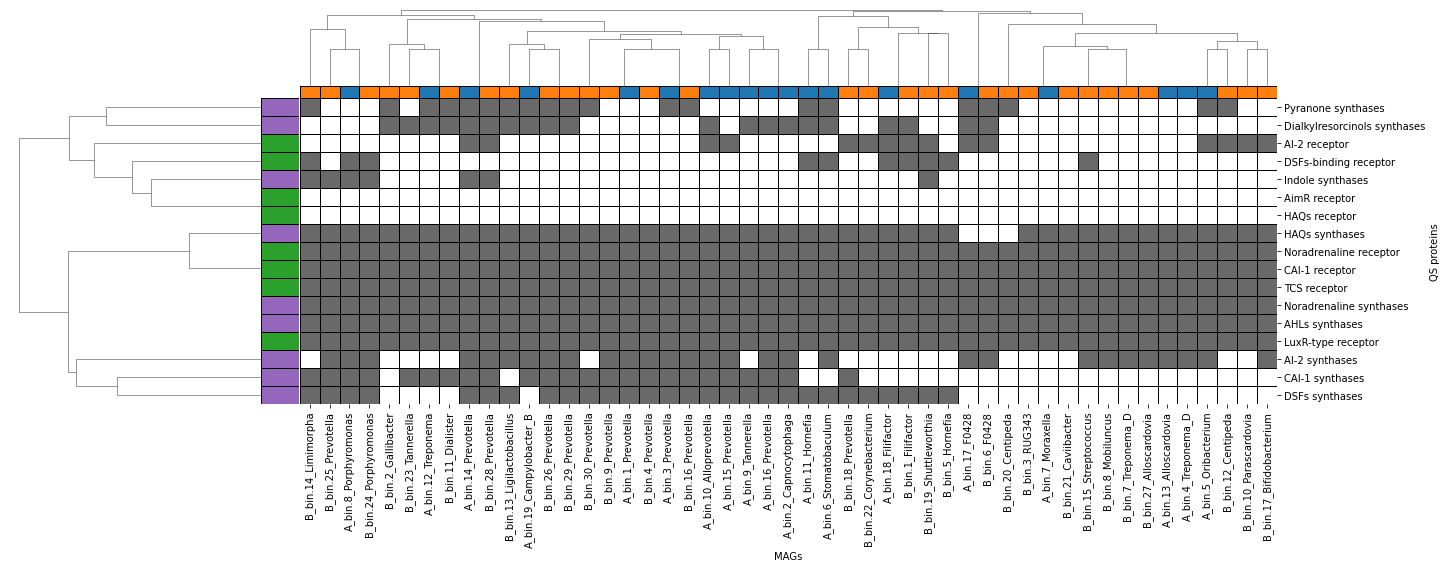

In [25]:
col_colors=['tab:blue'for i in range(19)]+['tab:orange'for i in range(30)]; row_colors=[];
for qsp in qs_matched.index:
    if 'recep' in qsp:
        row_colors.append('tab:green')
    else:
        row_colors.append('tab:purple')
fg=sns.clustermap(qs_matched, figsize=(20,8),cmap =['white', 'dimgray'],cbar_kws={'ticks':[0,1.0]},
               col_colors=col_colors,row_colors=row_colors,linecolor='black',linewidths=1, cbar_pos=None)
fg.ax_heatmap.set_xlabel('MAGs')
fg.ax_heatmap.set_ylabel('QS proteins')

# AA biosynthesis

In [22]:
aa_path = pd.read_csv('../data/metagenome/gapmind_aa.csv')
for bin_id in Aclass.bin_id:
    aa_path = aa_path.rename(columns={'A_'+bin_id:'A_'+bin_id+'_'+list(Aclass[Aclass['bin_id']==bin_id]['genus'])[0] })
for bin_id in Bclass.bin_id:
    aa_path = aa_path.rename(columns={'B_'+bin_id:'B_'+bin_id+'_'+list(Bclass[Bclass['bin_id']==bin_id]['genus'])[0] })    
aa_path = aa_path.set_index('Pathway')

Text(1362.8749999999998, 0.5, 'Amino acid biosynthetic pathway')

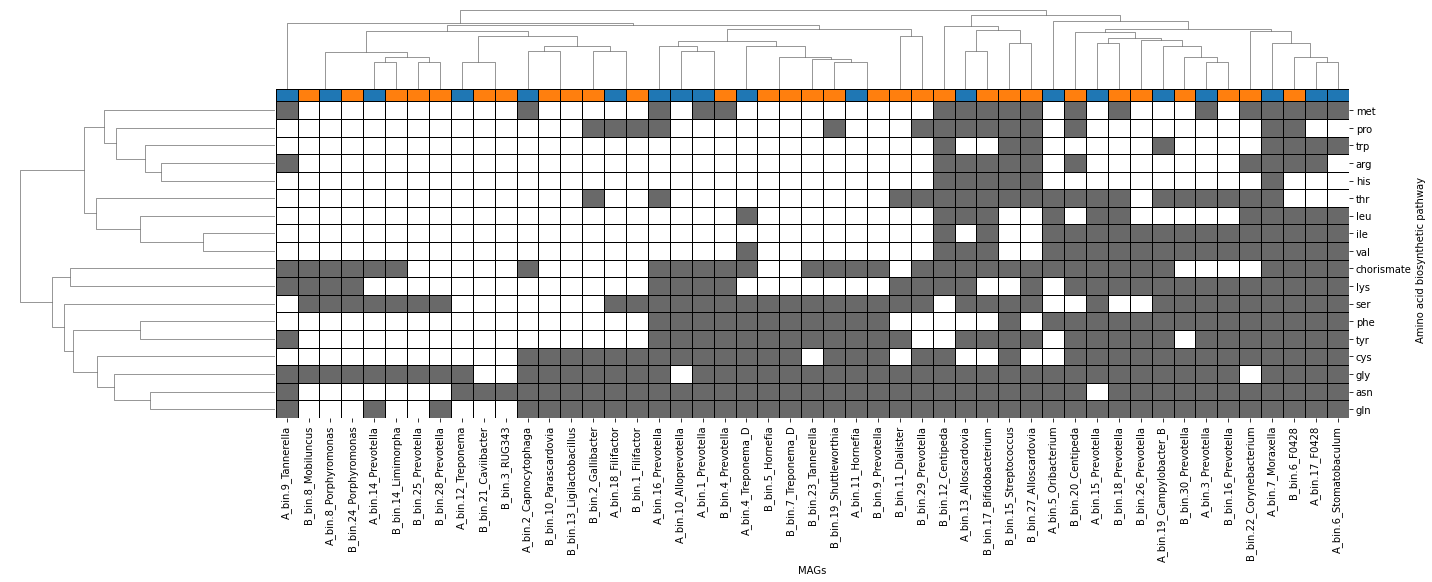

In [40]:
col_colors=['tab:blue'for i in range(19)]+['tab:orange'for i in range(30)]
fg=sns.clustermap(aa_path, figsize=(20,8),cmap =['white', 'dimgray'],cbar_kws={'ticks':[0,1.0]},
               col_colors=col_colors,linecolor='black',linewidths=1, cbar_pos=None)
fg.ax_heatmap.set_xlabel('MAGs')
fg.ax_heatmap.set_ylabel('Amino acid biosynthetic pathway')